<a href="https://colab.research.google.com/github/kupaqu/superdarn-nn/blob/main/27feb_superdarn_nn_pwr0_conv_synth.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class SyntheticGenerator:
    
    def __init__(self,
                 func,                          # функция по которой строится датасет
                 val=1,                         # период функции
                 target_width=60,               # ширина матрицы таргета
                 target_height=70,              # высота матрицы таргета
                 history_width=60*12*7):        # количество окон размера таргета в истории, размер=(70,60*12*7)

        self.func = func
        self.val = val
        self.target_width = target_width
        self.target_height = target_height
        self.history_width = history_width

    def __call__(self):
        for i in range(32*10):
        
            all = np.zeros((self.target_height, self.target_width+self.history_width, 1))
            for j in range(all.shape[1]):
                k = func(j+self.target_height*i)
                all[k, j] = k

            x = all[:, :self.history_width, :]
            y = all[:, self.history_width:, :]
            del all
            yield x, y

In [ ]:
from tensorflow import keras
import tensorflow as tf

In [ ]:
import numpy as np
def func(x):
    return int(((np.sin((x/(60*12-1))*2*np.pi - np.pi)+1)/2)*69)

batch_size = 16
train_dataset = tf.data.Dataset.from_generator(SyntheticGenerator(func), output_types=(tf.float64, tf.float64)).batch(batch_size)

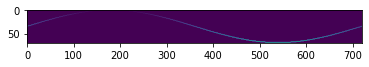

In [ ]:
for x, y in train_dataset:
    plt.imshow(x[0, :, :60*12])
    break

In [ ]:
# генератор
def get_generator():

    history = tf.keras.layers.Input(shape=(70, 5040, 1))

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same'
    )(history)

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(1, 7),
        dilation_rate=(1, 12*60),
        activation='relu'
    )(x)

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same'
    )(x)

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(1, 12),
        dilation_rate=(1, 60),
        activation='relu'
    )(x)

    output = tf.keras.layers.Conv2D(
        filters=1,
        kernel_size=1,
        activation='linear'
    )(x)

    generator = tf.keras.models.Model(history, output, name='generator')

    return generator

# дискриминатор
def get_discriminator():

    history = tf.keras.layers.Input(shape=(70, 5040, 1))
    target = tf.keras.layers.Input(shape=(70, 60, 1))
    concat = tf.keras.layers.Concatenate(axis=2)([history, target])
    
    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same'
    )(concat)

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(1, 7),
        dilation_rate=(1, 12*60),
        activation='relu'
    )(x)

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same'
    )(x)

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(1, 13),
        dilation_rate=(1, 60),
        activation='relu'
    )(x)

    x = tf.keras.layers.Conv2D(
        filters=1,
        kernel_size=(70, 1),
        activation='sigmoid'
    )(x)

    output = tf.keras.layers.Flatten()(x)
    
    discriminator = tf.keras.models.Model([history, target], output, name='discriminator')

    return discriminator

In [ ]:
class RadarGAN(keras.Model):
    def __init__(self, discriminator, generator):
        super(RadarGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.gen_mae_tracker = keras.metrics.Mean(name="generator_mae")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker, self.gen_mae_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(RadarGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.mae = keras.losses.MeanAbsoluteError()

    def train_step(self, data):

        # класс 1 - настоящие данные, класс 0 - дискриминированные данные
        x, y = data
        x_shape = tf.shape(x)
        y_shape = tf.shape(y)

        # обучение дискриминатора
        for step in range(1):
            
            # маска по Бернулли
            p = tf.constant([0.8])
            r = tf.random.uniform(shape=x_shape, maxval=1)
            b = tf.math.greater(p, r)
            f = tf.cast(b, dtype=tf.dtypes.float64)

            # выход генератора
            generated = tf.cast(self.generator(tf.math.multiply(x, f)), dtype=tf.dtypes.float64)

            with tf.GradientTape() as tape:
                real = self.discriminator([x, y])
                fake = self.discriminator([x, generated])
                
                # значения потерь на чистых данных
                loss_on_real = self.loss_fn(tf.ones_like(real), real)
                loss_on_fake = self.loss_fn(tf.zeros_like(fake), fake)
                
                # целевое значение дискриминатора
                real_mixed = tf.math.round(tf.random.uniform(shape=(y_shape[0], y_shape[2]), minval=0, maxval=1, dtype=tf.dtypes.float64))

                # маска для реальных данных
                real_mask_mixed = tf.reshape(real_mixed, shape=(y_shape[0], 1, y_shape[2], 1))
                real_mask_mixed = tf.repeat(real_mask_mixed, repeats=y_shape[1], axis=1)
                real_mask_mixed = tf.repeat(real_mask_mixed, repeats=y_shape[3], axis=3)
                # маска для фейковых данных
                fake_mask_mixed = tf.math.subtract(tf.ones(shape=tf.shape(real_mask_mixed), dtype=tf.dtypes.float64), real_mask_mixed)

                # перемешивание данных
                mixed = tf.math.add(tf.math.multiply(real_mask_mixed, y), tf.math.multiply(fake_mask_mixed, generated))

                predictions = self.discriminator([x, mixed])

                loss_on_mixed = self.loss_fn(real, predictions)

                d_loss = loss_on_real + loss_on_fake + loss_on_mixed

            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
        
        # таргет генератора как выход дискриминатора
        g_target = tf.ones(shape=tf.shape(real), dtype=tf.dtypes.float64)

        # тренировка генератора
        for step in range(1):
            with tf.GradientTape() as tape:

                # Бернулли
                p = tf.constant([0.8])
                r = tf.random.uniform(shape=x_shape, maxval=1)
                b = tf.math.greater(p, r)
                f = tf.cast(b, dtype=tf.dtypes.float64)

                generated = tf.cast(self.generator(tf.math.multiply(x, f)), dtype=tf.dtypes.float64)

                discriminated = self.discriminator([x, generated])
                g_loss = self.loss_fn(g_target, discriminated)
                g_mae = self.mae(y, generated)
                
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.gen_mae_tracker.update_state(g_mae)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "g_mae": self.gen_mae_tracker.result()
            }

    def test_step(self, data):
        # Unpack the data
        x, y = data
        y_shape = tf.shape(y)

        # Compute predictions
        generated = self.generator(x)
        real = self.discriminator([x, y], training=False)
        fake = self.discriminator([x, generated], training=False)

        # Compute losses
        g_target = tf.ones(shape=tf.shape(real), dtype=tf.dtypes.float64)
        g_loss = self.loss_fn(g_target, fake)
        g_mae = self.mae(y, generated)

        loss_on_real = self.loss_fn(tf.ones_like(real), real)
        loss_on_fake = self.loss_fn(tf.zeros_like(fake), fake)
        
        d_loss = loss_on_real + loss_on_fake

        # Update losses
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.gen_mae_tracker.update_state(g_mae)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "g_mae": self.gen_mae_tracker.result()
            }

In [ ]:
# если обучать с нуля
radar_gan = RadarGAN(discriminator=get_discriminator(), generator=get_generator())

# дообучение
# radar_gan = RadarGAN(discriminator=keras.models.load_model('drive/MyDrive/radargan_discriminator_new.hdf5'), generator=keras.models.load_model('drive/MyDrive/radargan_generator_new.hdf5'))

# графическое изображение структуры
tf.keras.utils.plot_model(radar_gan.generator, to_file='g.png', show_shapes=True)
tf.keras.utils.plot_model(radar_gan.discriminator, to_file='d.png', show_shapes=True)

radar_gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy()
)

In [ ]:
radar_gan.generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 70, 5040, 1)]     0         
                                                                 
 conv2d_5 (Conv2D)           (None, 70, 5040, 32)      832       
                                                                 
 conv2d_6 (Conv2D)           (None, 70, 720, 32)       7200      
                                                                 
 conv2d_7 (Conv2D)           (None, 70, 720, 32)       25632     
                                                                 
 conv2d_8 (Conv2D)           (None, 70, 60, 32)        12320     
                                                                 
 conv2d_9 (Conv2D)           (None, 70, 60, 1)         33        
                                                                 
Total params: 46,017
Trainable params: 46,017
Non-trainab

In [ ]:
radar_gan.discriminator.summary()

Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 70, 5040, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 70, 60, 1)]  0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 70, 5100, 1)  0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                      

In [ ]:
hist = radar_gan.fit(train_dataset, epochs=100)

Epoch 1/100
20/20 [==============================] - 38s 1s/step - g_loss: 0.7058 - d_loss: 2.0724 - g_mae: 0.8420
Epoch 2/100
20/20 [==============================] - 21s 1s/step - g_loss: 0.7405 - d_loss: 1.9411 - g_mae: 3.1823
Epoch 3/100
20/20 [==============================] - 20s 976ms/step - g_loss: 1.1335 - d_loss: 1.3179 - g_mae: 0.8899
Epoch 4/100
20/20 [==============================] - 20s 994ms/step - g_loss: 1.8144 - d_loss: 1.2072 - g_mae: 1.3779
Epoch 5/100
20/20 [==============================] - 20s 1s/step - g_loss: 1.7237 - d_loss: 1.0302 - g_mae: 1.2445
Epoch 6/100
20/20 [==============================] - 21s 1s/step - g_loss: 1.6230 - d_loss: 0.8431 - g_mae: 0.8088
Epoch 7/100
20/20 [==============================] - 20s 996ms/step - g_loss: 1.3904 - d_loss: 0.9340 - g_mae: 0.6440
Epoch 8/100
20/20 [==============================] - 20s 1s/step - g_loss: 1.3223 - d_loss: 1.1412 - g_mae: 0.4650
Epoch 9/100
20/20 [==============================] - 21s 1s/step - g_lo

In [ ]:
import matplotlib.pyplot as plt

def plot_output(gan, dataset, channel=0, n_examples=5):
    dataset = dataset.as_numpy_iterator()
    figure, axis = plt.subplots(4, n_examples)

    for i in range(n_examples):
        x, y = dataset.next()

        # шум
        # p = tf.constant([0.8])
        # r = tf.random.uniform(shape=tf.shape(x), maxval=1)
        # b = tf.math.greater(p, r)
        # f = tf.cast(b, dtype=tf.dtypes.float64)
        # x = tf.math.multiply(x, f)

        fake = radar_gan.generator.predict(x)
        d_real = radar_gan.discriminator.predict([x, y])
        d_fake = radar_gan.discriminator.predict([x, fake])

        axis[0, i].imshow(y[0, :, :, channel])
        axis[0, i].set_title("R")

        axis[1, i].imshow(fake[0, :, :, channel])
        axis[1, i].set_title("G")

        axis[2, i].imshow((y-fake)[0, :, :, channel])
        axis[2, i].set_title("R - G")

        axis[3, i].hist((y-fake)[0, :, :, channel])
        axis[2, i].set_title("R - G distr")

    plt.show()
    plt.hist

In [ ]:
radar_gan.generator.save('drive/MyDrive/radargan_generator_new.hdf5')
radar_gan.discriminator.save('drive/MyDrive/radargan_discriminator_new.hdf5')

1/1 [==============================] - 0s 43ms/step


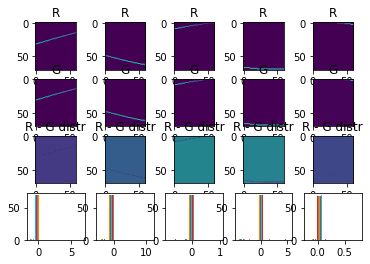

In [ ]:
plot_output(radar_gan, train_dataset)

In [ ]:
for x, y in train_dataset:
    fake = radar_gan.generator.predict(x)
    print('real: ', radar_gan.discriminator.predict([x, y]))
    print('fake: ', radar_gan.discriminator.predict([x, fake]))
    break

1/1 [==============================] - 0s 128ms/step
real:  [[0.9862597  0.98275536 0.99110466 0.9913517  0.9922191  0.99224454
  0.99237496 0.99299157 0.99203706 0.9935455  0.9931665  0.98820865
  0.9921875  0.98994446 0.99362236 0.99347645 0.9925096  0.9923153
  0.988699   0.99192786 0.993638   0.9946314  0.99559194 0.9944834
  0.99599224 0.9943926  0.9939294  0.9932058  0.98972636 0.9924899
  0.99180883 0.9932028  0.9922599  0.990845   0.9928544  0.99358714
  0.99340713 0.99128854 0.9932689  0.9914396  0.99096185 0.9896265
  0.99385864 0.99095297 0.9908627  0.9924419  0.99377316 0.9926616
  0.99069184 0.99336857 0.9911532  0.9910194  0.99294794 0.99440527
  0.99235266 0.9919927  0.98837364 0.98842174 0.97942334 0.9380234 ]
 [0.98657286 0.98424846 0.99125075 0.9910005  0.99256694 0.98972076
  0.98925924 0.991131   0.9927868  0.9943562  0.9944173  0.9950128
  0.9964952  0.99563724 0.99423695 0.99283326 0.9900461  0.9889198
  0.988538   0.98993766 0.9893484  0.9899738  0.99031913 0.991

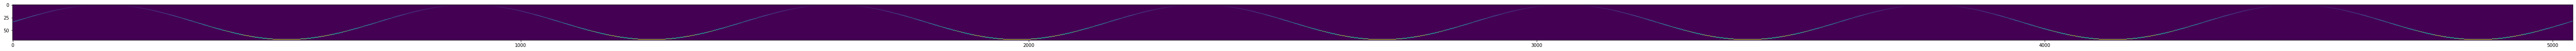

In [ ]:
for x, y in train_dataset:
    plt.figure(figsize=(100, 100))
    plt.imshow(x[0,:,:,0])
    break

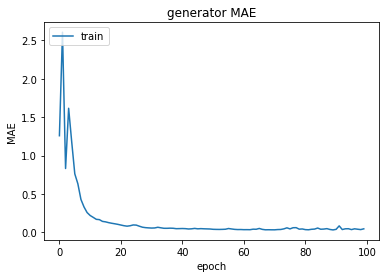

In [ ]:
plt.plot(hist.history['g_mae'])
plt.title('generator MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

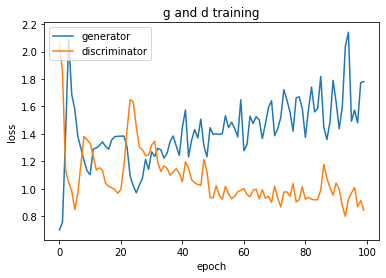

In [ ]:
plt.plot(hist.history['g_loss'])
plt.plot(hist.history['d_loss'])
plt.title('g and d training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper left')
plt.show()